In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download kapatsa/apple-prices-in-russian-regions

apple-prices-in-russian-regions.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
!unzip apple-prices-in-russian-regions.zip

Archive:  apple-prices-in-russian-regions.zip
  inflating: apples_ts.csv           


In [108]:
!pip install arm-mango

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import prophet
from sklearn.model_selection import train_test_split
from scipy.stats import uniform
from mango import scheduler, tuner
from warnings import filterwarnings
from sklearn.metrics import mean_absolute_percentage_error

In [73]:
file = ('apples_ts.csv')

df = pd.read_csv(file)

In [37]:
df.head()

,Unnamed: 0,1.2013,2.2013,3.2013,4.2013,5.2013,6.2013,7.2013,8.2013,9.2013,...,6.2019,7.2019,8.2019,9.2019,10.2019,11.2019,12.2019,1.2020,2.2020,3.2020
0,Moscow,79.72,81.08,79.68,79.80,80.63,80.80,80.28,78.99,76.77,...,116.91,125.29,123.94,113.03,102.19,97.83,101.07,103.44,108.23,110.28
1,Kaliningrad,42.67,44.37,44.73,46.75,49.93,51.59,57.80,62.14,56.76,...,79.20,80.85,85.33,75.02,77.95,78.98,76.55,74.89,70.00,81.53
2,Petersburg,62.55,62.73,63.43,63.83,66.06,69.22,72.07,69.31,65.18,...,115.35,123.03,123.08,109.71,97.22,95.75,97.09,98.18,103.10,110.60
3,Krasnodar,48.26,51.01,50.91,53.94,61.27,65.44,56.51,53.00,43.87,...,102.01,116.12,92.06,82.70,66.62,68.11,73.48,82.04,81.19,95.05
4,Ekaterinburg,71.25,71.35,70.90,71.92,72.91,74.39,73.10,70.24,69.12,...,121.68,125.32,123.41,108.48,98.73,96.25,100.12,101.29,102.81,108.53


In [38]:
df.describe()

,1.2013,2.2013,3.2013,4.2013,5.2013,6.2013,7.2013,8.2013,9.2013,10.2013,...,6.2019,7.2019,8.2019,9.2019,10.2019,11.2019,12.2019,1.2020,2.2020,3.2020
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000
mean,60.890000,62.108000,61.930000,63.248000,66.160000,68.288000,67.952000,66.736000,62.340000,60.034000,...,107.030000,114.122000,109.564000,97.788000,88.542000,87.384000,89.662000,91.968000,93.06600,101.198000
std,15.460752,14.862204,14.274574,13.307271,11.643436,10.972551,10.361248,9.732226,12.595001,13.670008,...,17.184067,18.976893,19.201173,17.569868,15.476882,13.227142,13.495083,12.721229,16.57297,12.740356
min,42.670000,44.370000,44.730000,46.750000,49.930000,51.590000,56.510000,53.000000,43.870000,42.120000,...,79.200000,80.850000,85.330000,75.020000,66.620000,68.110000,73.480000,74.890000,70.00000,81.530000
25%,48.260000,51.010000,50.910000,53.940000,61.270000,65.440000,57.800000,62.140000,56.760000,50.850000,...,102.010000,116.120000,92.060000,82.700000,77.950000,78.980000,76.550000,82.040000,81.19000,95.050000
50%,62.550000,62.730000,63.430000,63.830000,66.060000,69.220000,72.070000,69.310000,65.180000,62.130000,...,115.350000,123.030000,123.080000,108.480000,97.220000,95.750000,97.090000,98.180000,102.81000,108.530000
75%,71.250000,71.350000,70.900000,71.920000,72.910000,74.390000,73.100000,70.240000,69.120000,68.980000,...,116.910000,125.290000,123.410000,109.710000,98.730000,96.250000,100.120000,101.290000,103.10000,110.280000
max,79.720000,81.080000,79.680000,79.800000,80.630000,80.800000,80.280000,78.990000,76.770000,76.090000,...,121.680000,125.320000,123.940000,113.030000,102.190000,97.830000,101.070000,103.440000,108.23000,110.600000


In [74]:
new_columns = ["City"] + [i.replace("_", ".") for i in df.columns[1:]]
df.columns = new_columns
df_fg = df.transpose().reset_index().iloc[1:, :]
df_fg.columns = ['Date', 'Moscow',  'Kaliningrad',  'Petersburg',  'Krasnodar',  'Ekaterinburg']
df_fg['mean'] = df_fg.iloc[:, 1:5].mean(axis=1)
df_fg['std'] = df_fg.iloc[:, 1:5].std(axis=1)
df_fg['min'] = df_fg.iloc[:, 1:5].min(axis=1)
df_fg['max'] = df_fg.iloc[:, 1:5].max(axis=1)
df_fg.head()

,Date,Moscow,Kaliningrad,Petersburg,Krasnodar,Ekaterinburg,mean,std,min,max
1,1.2013,79.72,42.67,62.55,48.26,71.25,58.3000,16.552718,42.67,79.72
2,2.2013,81.08,44.37,62.73,51.01,71.35,59.7975,16.091118,44.37,81.08
3,3.2013,79.68,44.73,63.43,50.91,70.9,59.6875,15.432408,44.73,79.68
4,4.2013,79.8,46.75,63.83,53.94,71.92,61.0800,14.310013,46.75,79.80
5,5.2013,80.63,49.93,66.06,61.27,72.91,64.4725,12.719084,49.93,80.63


In [40]:
df.isnull().values.any()

False

In [41]:
df.head()

,City,_.2013,_.2013,_.2013,_.2013,_.2013,_.2013,_.2013,_.2013,_.2013,...,_.2019,_.2019,_.2019,_.2019,_0.2019,_1.2019,_2.2019,_.2020,_.2020,_.2020
0,Moscow,79.72,81.08,79.68,79.80,80.63,80.80,80.28,78.99,76.77,...,116.91,125.29,123.94,113.03,102.19,97.83,101.07,103.44,108.23,110.28
1,Kaliningrad,42.67,44.37,44.73,46.75,49.93,51.59,57.80,62.14,56.76,...,79.20,80.85,85.33,75.02,77.95,78.98,76.55,74.89,70.00,81.53
2,Petersburg,62.55,62.73,63.43,63.83,66.06,69.22,72.07,69.31,65.18,...,115.35,123.03,123.08,109.71,97.22,95.75,97.09,98.18,103.10,110.60
3,Krasnodar,48.26,51.01,50.91,53.94,61.27,65.44,56.51,53.00,43.87,...,102.01,116.12,92.06,82.70,66.62,68.11,73.48,82.04,81.19,95.05
4,Ekaterinburg,71.25,71.35,70.90,71.92,72.91,74.39,73.10,70.24,69.12,...,121.68,125.32,123.41,108.48,98.73,96.25,100.12,101.29,102.81,108.53


In [75]:
def new_df(df,col):
  df[['month','year']] = df[col].str.split('.', expand=True)
  df.drop(labels=col,axis=1,inplace=True)
  df['Date'] = pd.to_datetime(df[['month', 'year']].assign(DAY=1))
  return df

df = df.melt('City').query('value!=0')
df = df.rename(columns={'variable':'Date','value':'Prices'})
df = new_df(df,'Date')

In [78]:
df['Prices'].describe([0.10,0.30,0.50,0.70,0.80,0.95,0.99])

count    435.000000
mean      88.152943
std       21.361558
min       42.120000
10%       61.578000
30%       74.762000
50%       89.440000
70%      101.704000
80%      107.664000
95%      122.239000
99%      129.518400
max      133.290000
Name: Prices, dtype: float64

#data visualisation

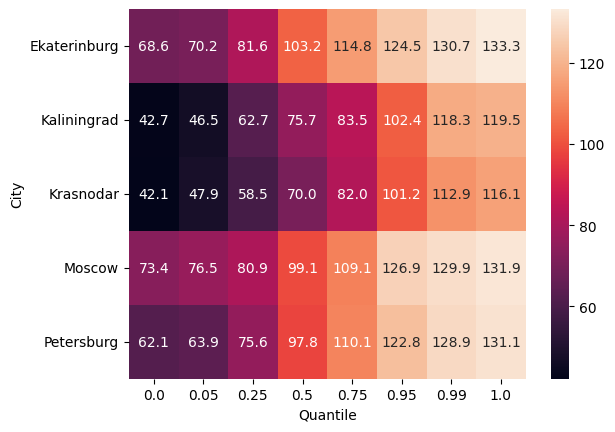

In [81]:
df_quantiles = df.groupby('City')['Prices'].quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1])
df_quantiles = df_quantiles.reset_index()
df_quantiles = df_quantiles.pivot_table(index="City", columns="level_1", values="Prices")
ax = sns.heatmap(df_quantiles, annot=True, fmt=".1f")
ax.set(xlabel="Quantile")
plt.show()

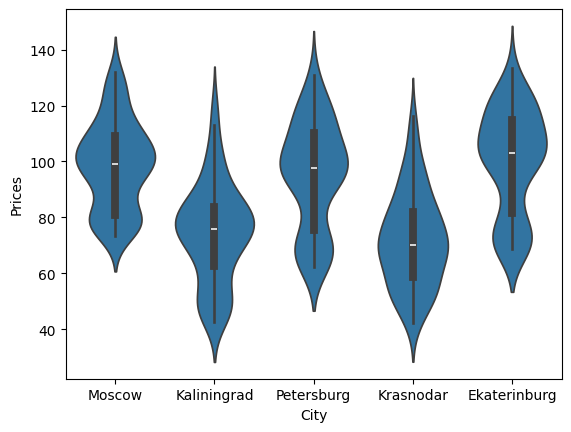

In [82]:
df_by_city = df.groupby('City').agg({'Prices':['sum','mean','median','std']})
df_by_city = df_by_city.reset_index()
df_by_city.columns = ['City', 'sum', 'mean', 'median', 'std']

sns.violinplot(data=df, x="City", y="Prices")
plt.show()

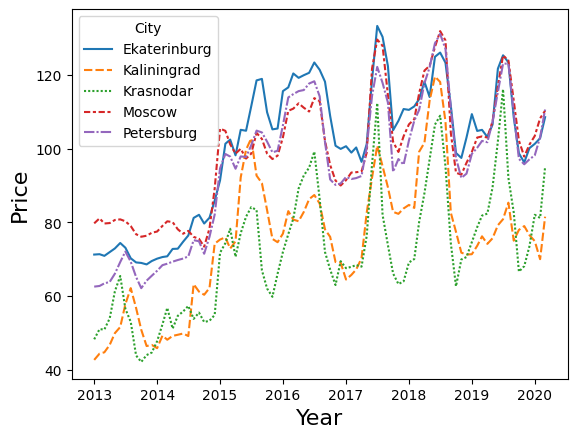

In [83]:
df_price_by_date = df.pivot_table('Prices', 'Date', 'City')
sns.lineplot(df_price_by_date)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.show()

In [85]:
df_ekaterinburg = df[df['City'] == 'Ekaterinburg']
df_kaliningrad = df[df['City'] == 'Kaliningrad']
df_krasnodar = df[df['City'] == 'Krasnodar']
df_moscow = df[df['City'] == 'Moscow']
df_petersburg = df[df['City'] == 'Petersburg']

In [86]:
df_moscow = df_moscow[['Date','Prices']]
df_moscow = df_moscow.reset_index()[['Date','Prices']]
df_moscow.columns = ['ds','y']

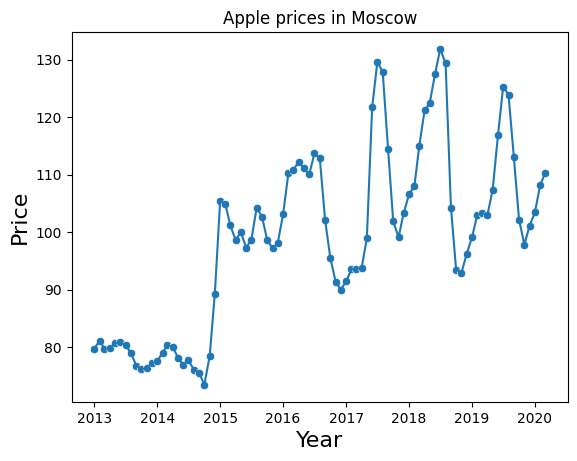

In [88]:
sns.scatterplot(x=df_moscow['ds'], y=df_moscow['y'])
sns.lineplot(x=df_moscow['ds'], y=df_moscow['y'])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title("Apple prices in Moscow")
plt.show()

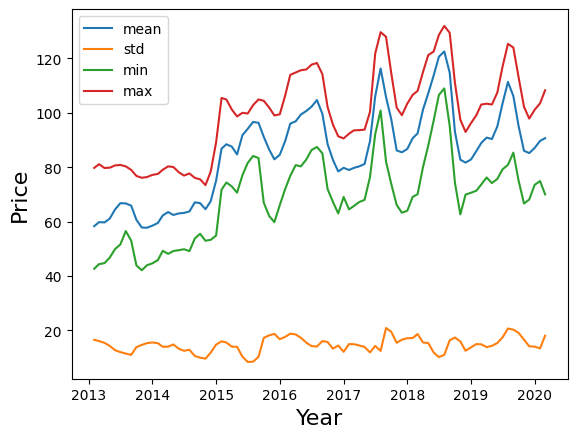

In [87]:
sns.lineplot(x=df_moscow['ds'], y=df_fg['mean'], label='mean')
sns.lineplot(x=df_moscow['ds'], y=df_fg['std'], label='std')
sns.lineplot(x=df_moscow['ds'], y=df_fg['min'], label='min')
sns.lineplot(x=df_moscow['ds'], y=df_fg['max'], label='max')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.show()

In [89]:
random_model = prophet.Prophet(n_changepoints  = np.random.randint(0, 10),
                   changepoint_range  = np.random.uniform(0, 1), #between 0 and 1
                   yearly_seasonality = True,
                   weekly_seasonality = False,
                   daily_seasonality = False,
                   seasonality_prior_scale= np.random.uniform(0, 20),
                   changepoint_prior_scale= np.random.uniform(0, 10),
                   interval_width = np.random.uniform(0.05, 0.95))
random_model.fit(df_moscow)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/t78wcge6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/nsfr7x_y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31577', 'data', 'file=/tmp/tmpkfnm3bju/t78wcge6.json', 'init=/tmp/tmpkfnm3bju/nsfr7x_y.json', 'output', 'file=/tmp/tmpkfnm3bju/prophet_modelw817kmpv/prophet_model-20240309164802.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:48:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:48:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE:  0.07991952324399539


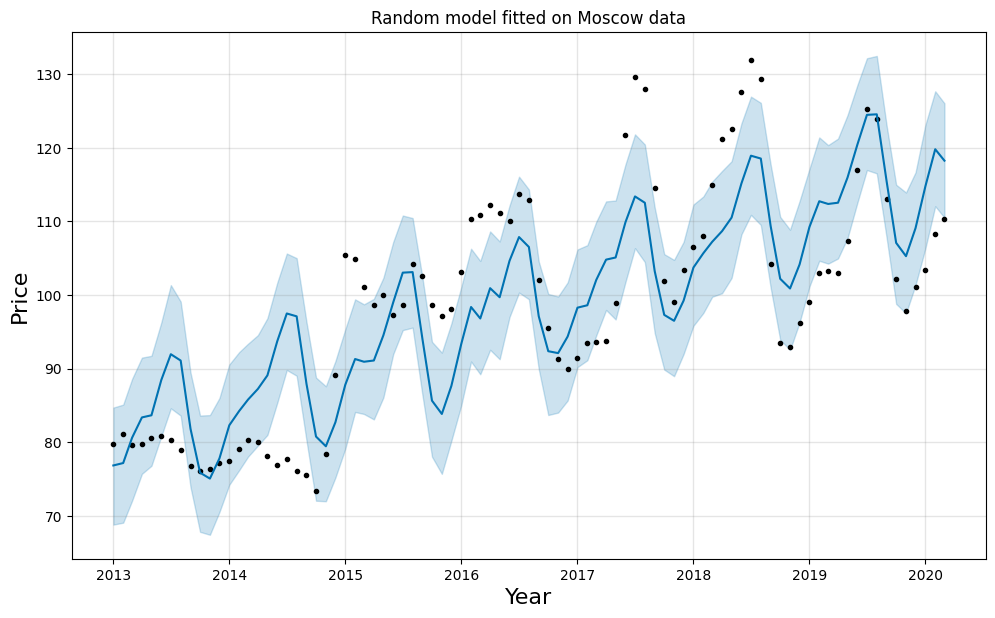

In [90]:
random_forecast_moscow = random_model.predict(df_moscow)
print("MAPE: ", mean_absolute_percentage_error(df_moscow['y'], random_model.predict(df_moscow)['yhat']), sep=" ")
random_graph_moscow = random_model.plot(random_forecast_moscow)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title("Random model fitted on Moscow data")
plt.show()

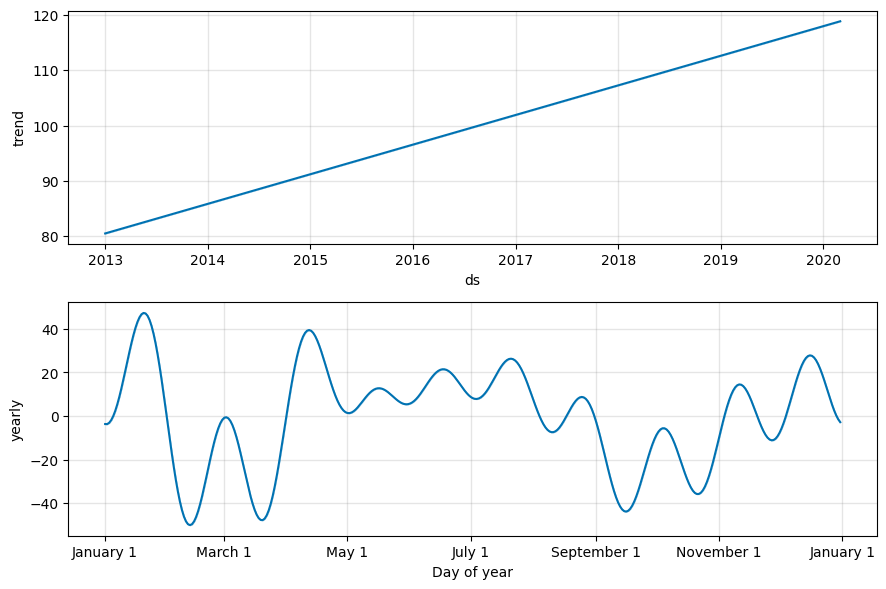

In [91]:
components_graph = random_model.plot_components(random_forecast_moscow)
plt.show()

In [93]:
base_model = prophet.Prophet()
base_model.fit(df_moscow)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/vj0bidrw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/cklo8ucm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39757', 'data', 'file=/tmp/tmpkfnm3bju/vj0bidrw.json', 'init=/tmp/tmpkfnm3bju/cklo8ucm.json', 'output', 'file=/tmp/tmpkfnm3bju/prophet_model2zw3667_/prophet_model-20240309164858.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:48:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:48:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [94]:
base_forecast_moscow = base_model.predict(df_moscow)
print("MAPE: ", mean_absolute_percentage_error(df_moscow['y'], base_model.predict(df_moscow)['yhat']), sep=" ")

MAPE:  0.06814729669616387


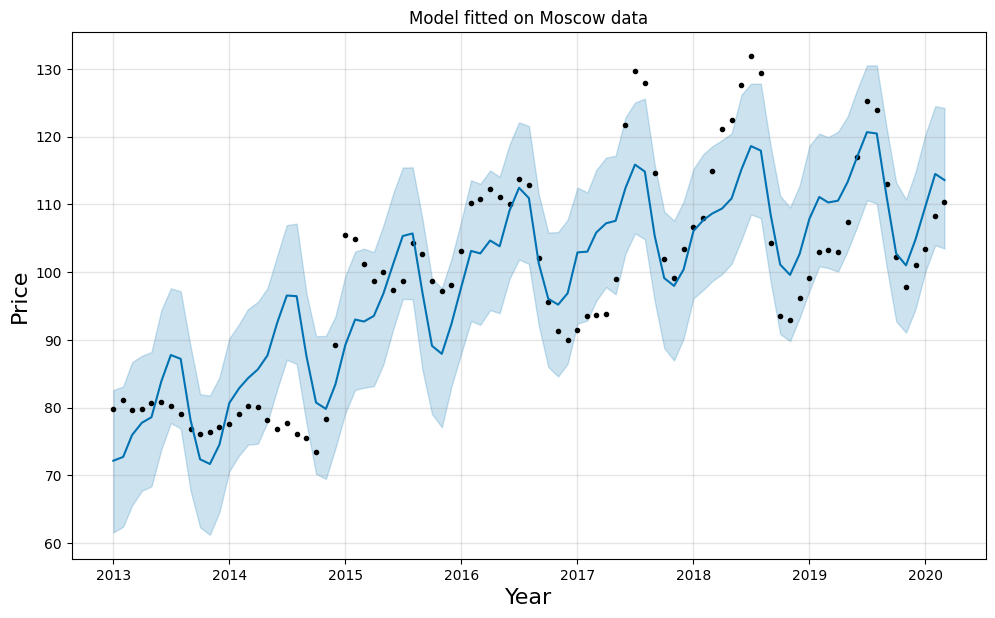

In [95]:
base_graph_moscow = base_model.plot(base_forecast_moscow)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title("Model fitted on Moscow data")
plt.show()

In [96]:
base_future_dates = base_model.make_future_dataframe(periods=36, freq='MS')
base_future_forecast = base_model.predict(base_future_dates)

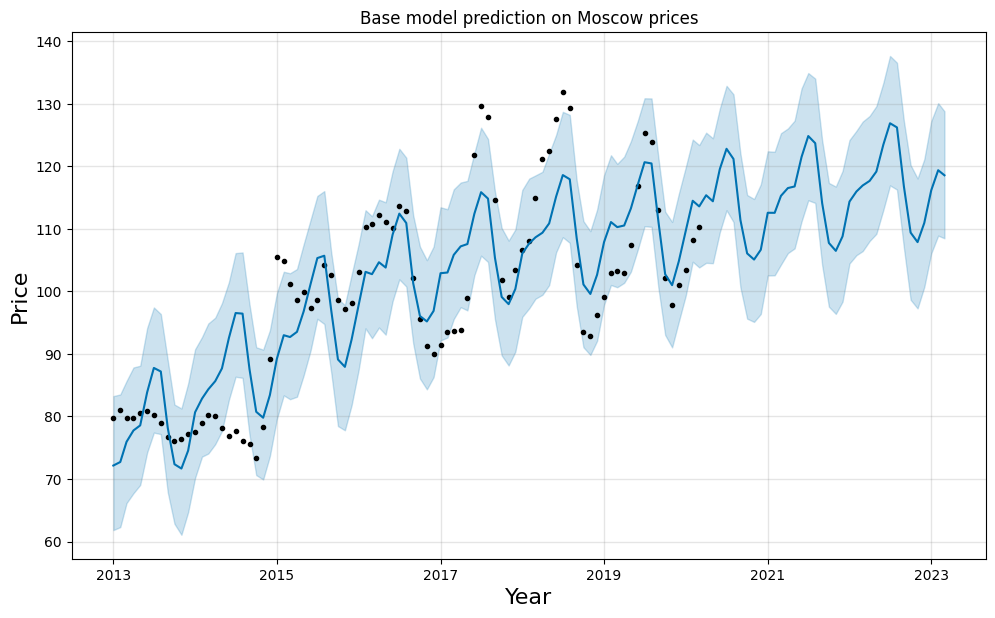

In [97]:
base_future_graph = base_model.plot(base_future_forecast)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title("Base model prediction on Moscow prices")
plt.show()

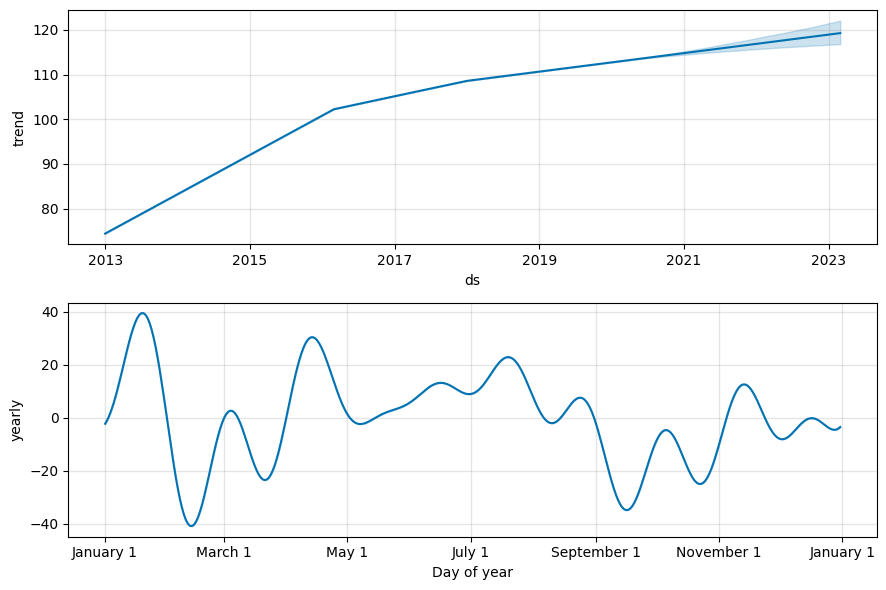

In [98]:
components_graph = base_model.plot_components(base_future_forecast)
plt.show()

In [99]:
train_moscow, test_moscow = train_test_split(df_moscow, test_size=0.25, shuffle=False)

In [149]:
#optimizing model
def objective_function(args_list):
    global train_moscow, test_moscow
    train_df = train_moscow
    test_df = test_moscow

    params_evaluated = []
    results = []

    for params in args_list:
            model = prophet.Prophet(**params)
            model.fit(train_df)
            future = model.make_future_dataframe(periods=len(test_df), freq='MS')
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(len(test_df))
            error = mean_absolute_percentage_error(test_df['y'], predictions_tuned['yhat'])

            params_evaluated.append(params)
            results.append(error)
    return params_evaluated, results


param_space = dict(n_changepoints  = range(0, 10),
                   changepoint_range  = uniform(0.0, 1), #between 0 and 1
                   yearly_seasonality = [True],
                   weekly_seasonality = [False],
                   daily_seasonality = [False],
                   seasonality_prior_scale= uniform(0, 10),
                   changepoint_prior_scale= uniform(0, 10),
                   interval_width = uniform(0.05, 0.95), #percentiles
                   )

In [102]:
conf_Dict = dict()
conf_Dict['batch_size'] = 8
conf_Dict['initial_random'] = 20
conf_Dict['num_iteration'] = 60

In [150]:
mod_tuner = tuner.Tuner(param_space, objective_function, conf_Dict)
results = mod_tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/f8i6aebf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/8mj_pkfh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79190', 'data', 'file=/tmp/tmpkfnm3bju/f8i6aebf.json', 'init=/tmp/tmpkfnm3bju/8mj_pkfh.json', 'output', 'file=/tmp/tmpkfnm3bju/prophet_modeldruksoda/prophet_model-20240309170937.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:09:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/kzhkpxp_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/fn1f410_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/60 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/qfvh0c_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/sztqpd0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20505', 'data', 'file=/tmp/tmpkfnm3bju/qfvh0c_v.json', 'init=/tmp/tmpkfnm3bju/sztqpd0b.json', 'output', 'file=/tmp/tmpkfnm3bju/prophet_modelv2ixq100/prophet_model-20240309170948.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:09:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/1j7z1r2_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/fp2cwae_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

best parameters: {'changepoint_prior_scale': 9.985712758481421, 'changepoint_range': 0.9210914948565649, 'daily_seasonality': False, 'interval_width': 0.9134371649469271, 'n_changepoints': 7, 'seasonality_prior_scale': 8.40862732643689, 'weekly_seasonality': False, 'yearly_seasonality': True}
best loss: 0.06819066587318345


{'random_params': array([{'changepoint_prior_scale': 7.444769991102374, 'changepoint_range': 0.29473600010887857, 'daily_seasonality': False, 'interval_width': 0.9853145624526993, 'n_changepoints': 5, 'seasonality_prior_scale': 2.5633228739846303, 'weekly_seasonality': False, 'yearly_seasonality': True},
       {'changepoint_prior_scale': 7.413968370103178, 'changepoint_range': 0.8995144859425056, 'daily_seasonality': False, 'interval_width': 0.4069875934935848, 'n_changepoints': 4, 'seasonality_prior_scale': 2.260268153137246, 'weekly_seasonality': False, 'yearly_seasonality': True},
       {'changepoint_prior_scale': 0.5541876277807756, 'changepoint_range': 0.3244984104149906, 'daily_seasonality': False, 'interval_width': 0.42527970962963096, 'n_changepoints': 2, 'seasonality_prior_scale': 8.036827844465156, 'weekly_seasonality': False, 'yearly_seasonality': True},
       {'changepoint_prior_scale': 6.30960322484513, 'changepoint_range': 0.7145392397855541, 'daily_seasonality': False

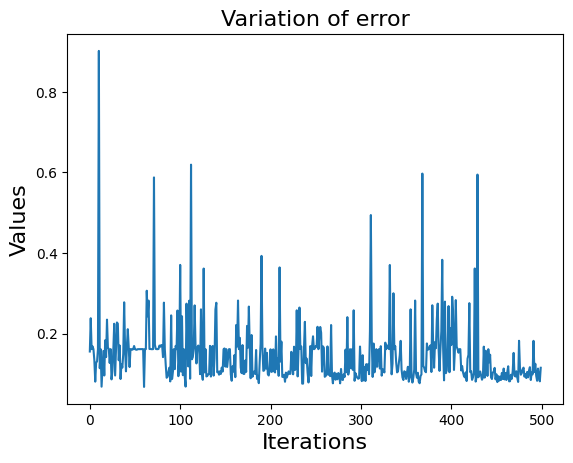

In [151]:
print(results)
sns.lineplot(x=range(len(results['objective_values'])), y=results['objective_values'])
plt.title('Variation of error',fontsize=16)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Values',fontsize=16)
plt.show()

In [152]:
tuned_model = prophet.Prophet(**results['best_params'])
tuned_model.fit(df_moscow)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/n98281e4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfnm3bju/ve_nmxon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44029', 'data', 'file=/tmp/tmpkfnm3bju/n98281e4.json', 'init=/tmp/tmpkfnm3bju/ve_nmxon.json', 'output', 'file=/tmp/tmpkfnm3bju/prophet_modelporgaadu/prophet_model-20240309173241.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:32:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [153]:
tuned_future_dates = tuned_model.make_future_dataframe(periods=60, freq='MS')
tuned_forecast_moscow = tuned_model.predict(tuned_future_dates)
print("MAPE: ", mean_absolute_percentage_error(df_moscow['y'], tuned_model.predict(df_moscow)['yhat']), sep=" ")

MAPE:  0.057661353463280184


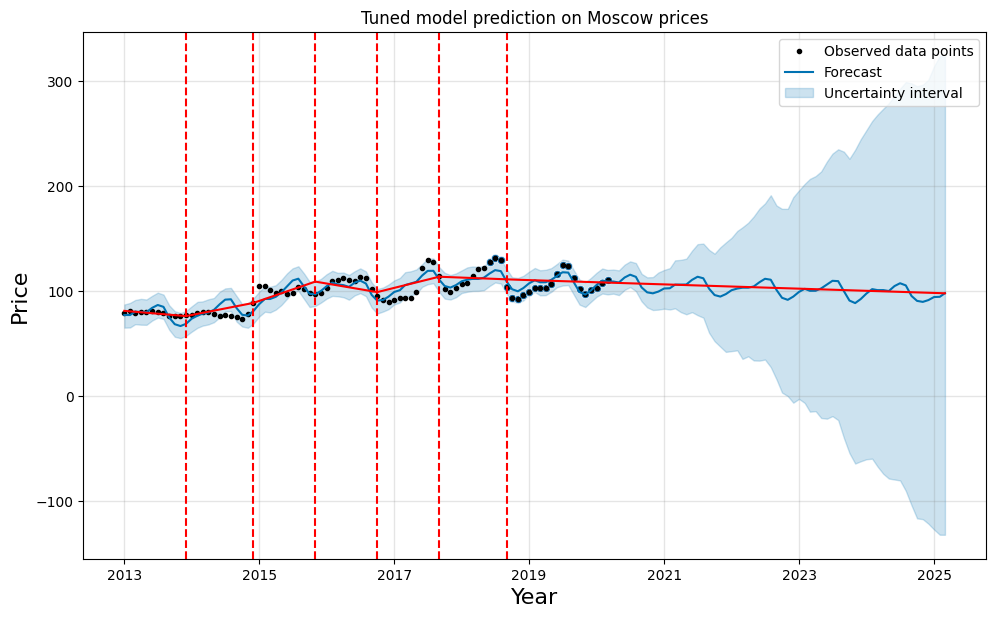

In [154]:
tuned_graph_moscow = tuned_model.plot(tuned_forecast_moscow)
a = prophet.plot.add_changepoints_to_plot(tuned_graph_moscow.gca(), tuned_model, tuned_forecast_moscow)
sns.scatterplot(x=test_moscow['ds'], y=test_moscow['y'])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title("Tuned model prediction on Moscow prices")
plt.show()

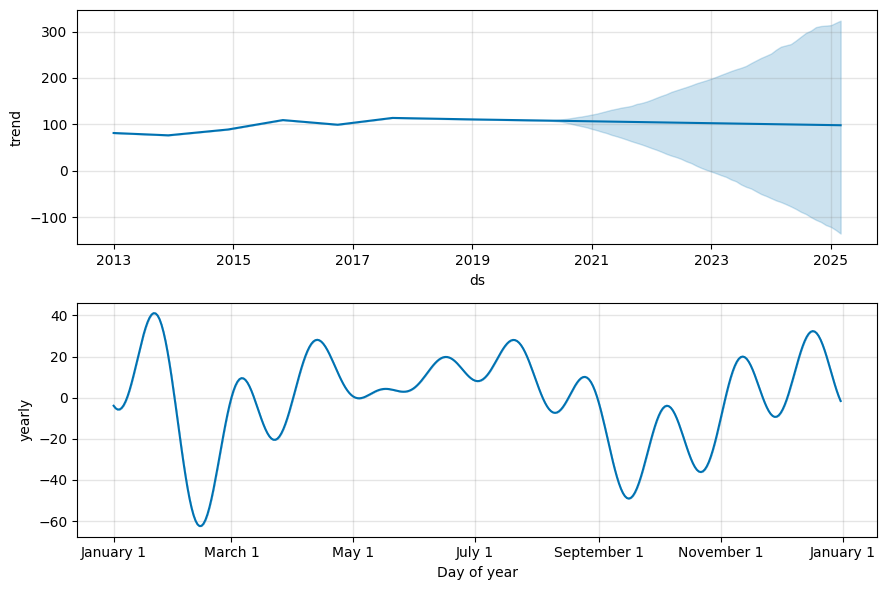

In [155]:
components_graph = tuned_model.plot_components(tuned_forecast_moscow)
plt.show()